Установка библиотек и окружения (требуется перезагрузка для установки всех взаимосвязей)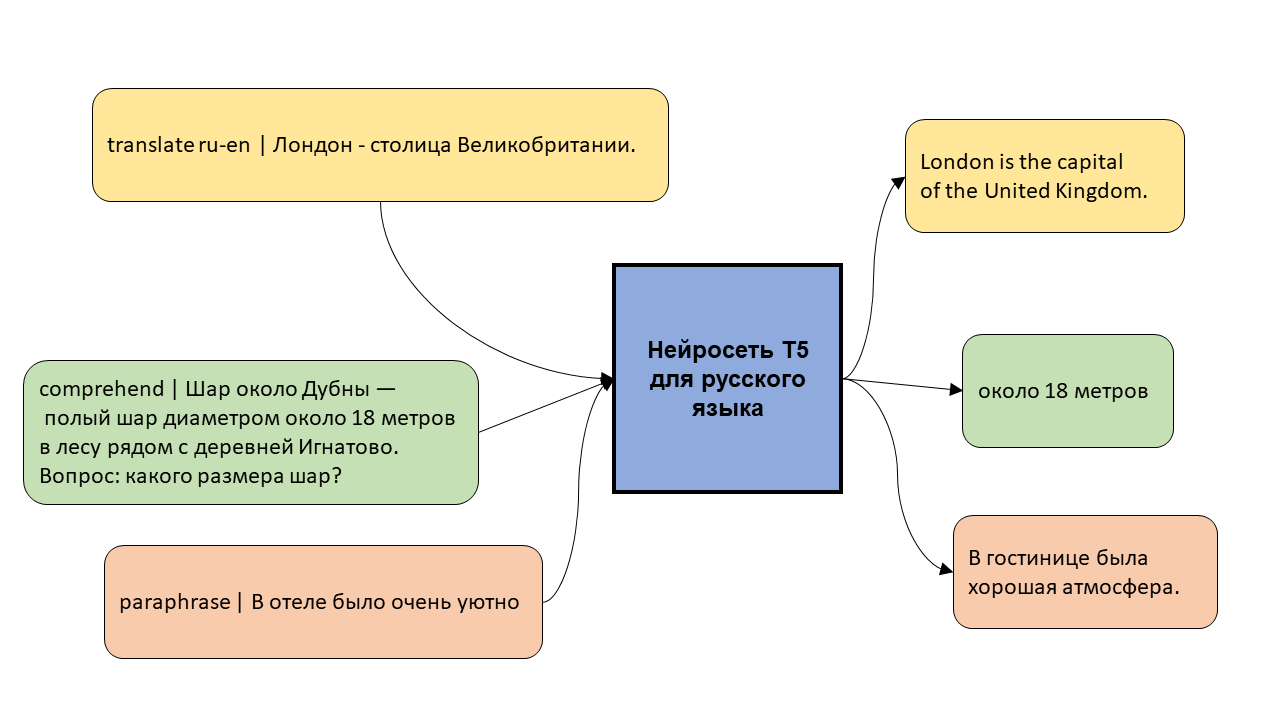

In [ ]:
!pip install rouge_score -qU
!pip install sentencepiece -qU
!pip install rouge_score googletrans -qU
!pip install rouge-score bert-score -qU
!pip install transformers -qU
!python -m spacy download ru_core_news_md -qU

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=5f381fcf82b2efd5519b3560fd38a6ad6aee63a613bd9cdcb8601a70b7b26b66
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


Загрузка данных в среду

In [1]:
import os
from google.colab import drive

# Монтируем Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
import pandas as pd

zip_path = '/content/drive/MyDrive/коменты хак/dataset.jsonl.zip'

extract_path = '/content/drive/MyDrive/коменты хак/'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


FileNotFoundError: ignored

In [2]:
import pandas as pd
import re
data = pd.read_json('/content/drive/MyDrive/коменты хак/dataset.jsonl',lines=True)
df = pd.DataFrame(data)




Предобработка данных

In [3]:
def clean_up (text):
  #Функция удаляет из текста спецсимвол пробела и ссылки
  text = text.replace('<br />\n', ' ').replace('\n', ' '). replace('<b>', ' ').replace('<br>', ' ').replace('</b>', ' ').replace('</i>', ' ')
  text = text.replace('<a href="', ' ').replace('</a>', ' ').replace('<i>', ' ').replace('<hr/>', ' ').replace('<br/>', ' ')
  text = re.sub(r"https?://[^,\s]+,?", ' ', text)
  #удаление смайлов
  text = re.sub('[^\x00-\x7Fа-яА-Я]', '', text)

  return text

In [4]:
df['text'] = df['text'].apply(lambda x: clean_up(x))

In [5]:
import pandas as pd

batch_size = 1000
batches = [df[i:i + batch_size] for i in range(0, df.shape[0], batch_size)]

processed_posts = []
processed_comments = []

for batch in batches:
    posts = batch[batch['root_id'].isna()]
    comments = batch[~batch['root_id'].isna()]

    processed_posts_batch = posts[['text', 'url', 'hash', 'id', 'date']].copy()

    processed_comments_batch = comments[['text', 'url', 'hash', 'id', 'date', 'root_id', 'parent_id']].copy()

    processed_posts.append(processed_posts_batch)
    processed_comments.append(processed_comments_batch)

df_processed_posts = pd.concat(processed_posts, ignore_index=True)
df_processed_comments = pd.concat(processed_comments, ignore_index=True)

all_comments = df_processed_comments.groupby('root_id')['text'].apply(lambda x: ' '.join(x)).reset_index()
all_comments_hash = df_processed_comments.groupby('root_id')['hash'].apply(lambda x: ', '.join(x)).reset_index()
all_comments_summary = pd.merge(all_comments, all_comments_hash, on='root_id', how='left')
all_comments_summary = pd.merge(all_comments_summary, df_processed_posts[['id', 'text']], left_on='root_id', right_on='id', how='left')
all_comments_summary = all_comments_summary.rename(columns={'id': 'post_id', 'text_x': 'comments', 'text_y': 'post_text', 'hash': 'comment_hashes'})
all_comments_summary = all_comments_summary[['post_id', 'comments', 'post_text', 'comment_hashes']]

post_comments = df_processed_comments[~df_processed_comments['parent_id'].notna()]
post_comments_hash = df_processed_comments[~df_processed_comments['parent_id'].notna()].groupby('root_id')['hash'].apply(lambda x: ', '.join(x)).reset_index()
post_comments_summary = pd.merge(post_comments, post_comments_hash, on='root_id', how='left')
post_comments_summary = pd.merge(post_comments_summary, df_processed_posts[['id', 'text']], left_on='root_id', right_on='id', how='left')
post_comments_summary = post_comments_summary.rename(columns={'id': 'post_id', 'text_x': 'comments', 'text_y': 'post_text', 'hash': 'comment_hashes'})
#post_comments_summary = post_comments_summary[['post_id', 'comments', 'post_text', 'comment_hashes']]

topic_comments = df_processed_comments[df_processed_comments['parent_id'].notna()]
topic_comments_hash = df_processed_comments[df_processed_comments['parent_id'].notna()].groupby('root_id')['hash'].apply(lambda x: ', '.join(x)).reset_index()
topic_comments_summary = pd.merge(topic_comments, topic_comments_hash, on='root_id', how='left')
topic_comments_summary = pd.merge(topic_comments_summary, df_processed_posts[['id', 'text']], left_on='root_id', right_on='id', how='left')
topic_comments_summary = topic_comments_summary.rename(columns={'id': 'post_id', 'text_x': 'comments', 'text_y': 'post_text', 'hash': 'comment_hashes'})
#topic_comments_summary = topic_comments_summary[['post_id', 'comments', 'post_text', 'comment_hashes']]

#print(all_comments_summary)
#print(post_comments_summary)
#print(topic_comments_summary)


<ipython-input-5-c2f289844147>:41: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  post_comments_hash = df_processed_comments[~df_processed_comments['parent_id'].notna()].groupby('root_id')['hash'].apply(lambda x: ', '.join(x)).reset_index()


Аутентификация на сайте hugginface (если работаете не локально)

In [ ]:
!pip install hugginface_hub
from huggingface_hub import notebook_login
notebook_login()

ERROR: Could not find a version that satisfies the requirement hugginface_hub (from versions: none)
ERROR: No matching distribution found for hugginface_hub


FINE-TUNING MODELS

In [6]:
all_comments_summary=all_comments_summary[:100]

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 4
max_seq_length = 128
input_ids = tokenizer(list(all_comments_summary["comments"]), return_tensors="pt", padding=True, truncation=True, max_length=max_seq_length).input_ids.to(device)
labels = tokenizer(list(all_comments_summary["post_text"]), return_tensors="pt", padding=True, truncation=True, max_length=max_seq_length).input_ids.to(device)

optimizer = AdamW(model.parameters(), lr=1e-4)
epochs = 6
accumulation_steps = 2

for epoch in range(epochs):
    for step in range(0, len(input_ids), accumulation_steps):
        batch_input_ids = input_ids[step: step + accumulation_steps]
        batch_labels = labels[step: step + accumulation_steps]
        outputs = model(input_ids=batch_input_ids, labels=batch_labels)
        loss = outputs.loss
        loss.backward()

        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
l
model.save_pretrained("fine_tuned_t5_model")
tokenizer.save_pretrained("fine_tuned_t5_model")

generated_post_texts = []
for comment in all_comments_summary["comments"]:
    input_ids = tokenizer(comment, return_tensors="pt", padding=True, truncation=True, max_length=max_seq_length).input_ids.to(device)
    output_ids = model.generate(input_ids)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    generated_post_texts.append(generated_text)

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(generated_post_texts + list(all_comments_summary["post_text"]))
cosine_similarities = cosine_similarity(tfidf_matrix[:len(generated_post_texts)], tfidf_matrix[len(generated_post_texts):])

max_cosine_similarities = cosine_similarities.max(axis=1)

print("Max Cosine Similarities:", max_cosine_similarities)


**Обработка данных моделями**


Модель T5 (предобученная для русского языка):

T5 — это модель кодера-декодера, предварительно обученная на многозадачной смеси неконтролируемых и контролируемых задач, для которой каждая задача преобразуется в текстовый формат. T5 отлично справляется с различными задачами, добавляя в начало разные префиксы для ввода, соответствующие каждой задаче, например, для перевода: перевести с английского на немецкий: …, для обобщения: подвести итог:

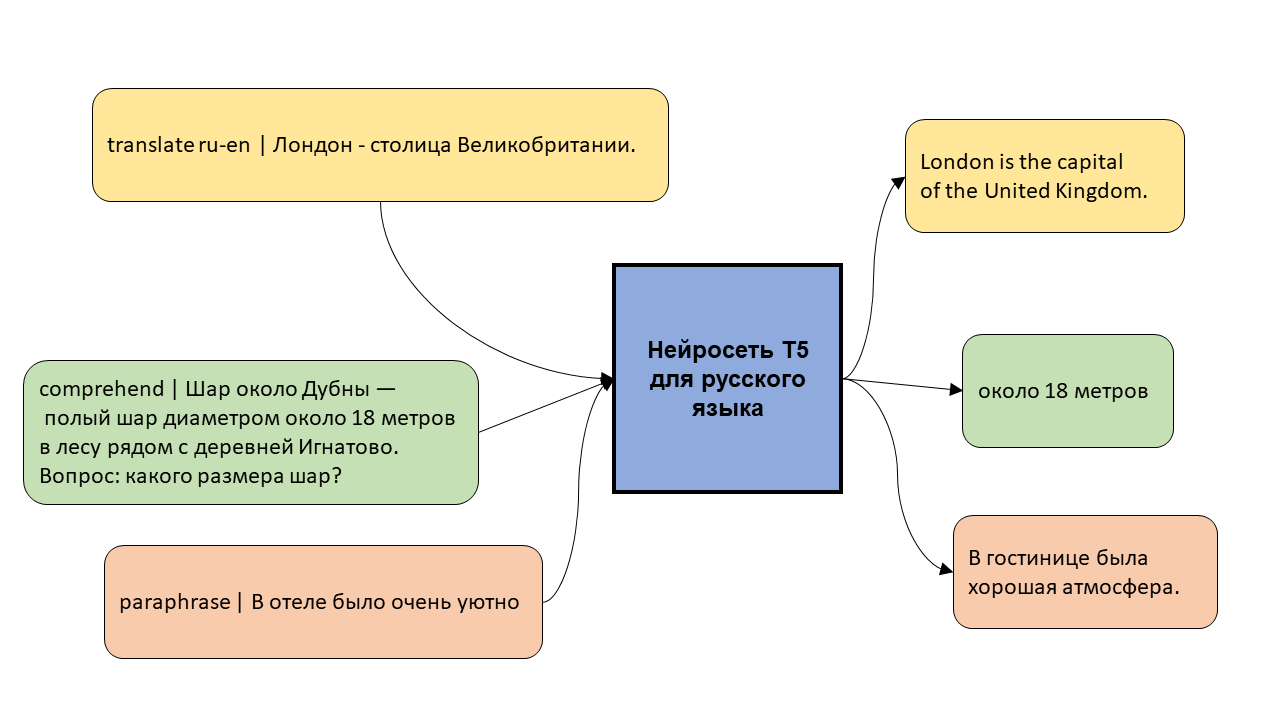


In [9]:

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("d0rj/rut5-base-summ")
model = AutoModelForSeq2SeqLM.from_pretrained("d0rj/rut5-base-summ")

tokenizer_config.json:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

In [13]:
def generate_summary(row):
    text_to_summarize = row['comments']


    model.to("cuda")

    input_ids = tokenizer.encode(text_to_summarize, return_tensors="pt", max_length=1024, truncation=True).to("cuda")
    summary_ids = model.generate(input_ids, max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return generated_summary


all_comments_summary['summary_detox'] = all_comments_summary.apply(generate_summary, axis=1)


print(all_comments_summary['summary_detox'][6])


Batch 1/1, Time per batch: 18.8425 seconds
Total time taken: 18.84 seconds


<ipython-input-13-7b20a9e3b15d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start_index:end_index - 1, summary_column] = results


In [15]:
all_comments_summary['summary_comments'][0]

'В сети появилось видео, в котором женщина подзывает к бабкам своего деду после обеда Трека.'

Проверка точности предсказания с помощью метрики ROUGE


In [ ]:
import pandas as pd
from bert_score import score
import numpy as np




all_comments_summary['summary_detox'].fillna("", inplace=True)
all_comments_summary['post_text'].fillna("", inplace=True)


references = all_comments_summary['summary_detox'].tolist()
hypotheses = all_comments_summary['post_text'].tolist()

P, R, F1 = score(hypotheses, references, lang="ru", rescale_with_baseline=True)

bert_score_df = pd.DataFrame({'Precision': P.tolist(), 'Recall': R.tolist(), 'F1 Score': F1.tolist()})

print(bert_score_df)


   Precision    Recall  F1 Score
0   0.605660  0.610201  0.607922
1   0.581303  0.596808  0.588953
2   0.615749  0.645947  0.630486
3   0.561264  0.565778  0.563512
4   0.561025  0.650119  0.602295
5   0.710820  0.682471  0.696357
6   0.548228  0.644799  0.592605
7   0.574176  0.621364  0.596839
8   0.548900  0.655225  0.597368
9   0.525594  0.678140  0.592201


In [ ]:

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rut5-base-multitask",use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained("cointegrated/rut5-base-multitask")

In [8]:
import concurrent.futures
import time
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

MODEL_NAME = "cointegrated/rut5-base-multitask"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TARGET_TIME_PER_BATCH = 2.0


def initialize_model():

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
    model.to(DEVICE)
    return model, tokenizer

def summarize(text, model, tokenizer, n_words=20, max_length=10000, num_beams=2, do_sample=True, repetition_penalty=20.0, **kwargs):
    if n_words:
        text = f'[{n_words}] {text}'
    inputs = tokenizer(text, return_tensors='pt', padding=True).to(DEVICE)

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_length=max_length,
            num_beams=num_beams,
            do_sample=do_sample,
            repetition_penalty=repetition_penalty,
            **kwargs
        )

    return tokenizer.decode(out[0], skip_special_tokens=True)


def summarize_batch(batch, model, tokenizer, cache):
    return [cache[text] if text in cache else cache.setdefault(text, summarize(text, model, tokenizer)) for text in batch]


def process_batch(batch, model, tokenizer, cache):
    return summarize_batch(batch, model, tokenizer, cache)


def add_summary_column(df, column='comments', summary_column='summary_comments', batch_size=256):
    model, tokenizer = initialize_model()
    data = df[column]

    cache = {}

    num_batches = -(-len(data) // batch_size)
    start_time = time.time()

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for i in range(num_batches):
            start_index = i * batch_size
            end_index = min((i + 1) * batch_size, len(data))
            batch_data = data[start_index:end_index]


            future_data = executor.submit(process_batch, batch_data, model, tokenizer, cache.copy())

            futures.append(future_data)


        for future in concurrent.futures.as_completed(futures):
            results = future.result()
            start_index = futures.index(future) * batch_size
            end_index = start_index + len(results)


            df.loc[start_index:end_index - 1, summary_column] = results


            elapsed_time = time.time() - start_time
            batch_number = len(futures)
            time_per_batch = elapsed_time / batch_number if batch_number > 0 else 0.0
            print(f"Batch {batch_number}/{num_batches}, Time per batch: {time_per_batch:.4f} seconds")

            if elapsed_time < TARGET_TIME_PER_BATCH * batch_number:
                time.sleep(TARGET_TIME_PER_BATCH * batch_number - elapsed_time)

    total_time = time.time() - start_time
    print(f"Total time taken: {total_time:.2f} seconds")

    return df


all_comments_summary = add_summary_column(all_comments_summary, column='comments', summary_column='summary_comments')

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

OutOfMemoryError: ignored

In [ ]:
import pandas as pd
from bert_score import score
import numpy as np



all_comments_summary['summary_detox'].fillna("", inplace=True)
all_comments_summary['post_text'].fillna("", inplace=True)

references = all_comments_summary['summary_detox'].tolist()
hypotheses = all_comments_summary['post_text'].tolist()

P, R, F1 = score(hypotheses, references, lang="ru", rescale_with_baseline=True)

bert_score_df = pd.DataFrame({'Precision': P.tolist(), 'Recall': R.tolist(), 'F1 Score': F1.tolist()})

print(bert_score_df)


   Precision    Recall  F1 Score
0   0.560420  0.588325  0.574033
1   0.551836  0.650903  0.597289
2   0.552718  0.626033  0.587096
3   0.550214  0.611285  0.579144
4   0.520611  0.699234  0.596844
5   0.729975  0.792507  0.759957
6   0.500199  0.647878  0.564540
7   0.482937  0.667770  0.560509
8   0.515504  0.632231  0.567932
9   0.523621  0.620786  0.568079


In [ ]:

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Natet/rut5_base_sum_gazeta-finetuned")
model = AutoModelForSeq2SeqLM.from_pretrained("Natet/rut5_base_sum_gazeta-finetuned")

In [ ]:
def generate_summary(row):
    text_to_summarize = row['comments']

    model.to("cuda")

    input_ids = tokenizer.encode(text_to_summarize, return_tensors="pt", max_length=1024, truncation=True).to("cuda")
    summary_ids = model.generate(input_ids, max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return generated_summary


all_comments_summary['summary_detox'] = all_comments_summary.apply(generate_summary, axis=1)

print(all_comments_summary['summary_detox'][6])


In [ ]:

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rut5-base-multitask")
model = AutoModelForSeq2SeqLM.from_pretrained("cointegrated/rut5-base-multitask")

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [9]:
def generate_summary(row):
    text_to_summarize = row['comments']

    model.to("cuda")

    input_ids = tokenizer.encode(text_to_summarize, return_tensors="pt", max_length=1024, truncation=True).to("cuda")
    summary_ids = model.generate(input_ids, max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return generated_summary

all_comments_summary['summary_detox'] = all_comments_summary.apply(generate_summary, axis=1)

print(all_comments_summary['summary_detox'][6])


tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/828k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/753 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
from bert_score import score
import numpy as np


all_comments_summary['summary_detox'].fillna("", inplace=True)
all_comments_summary['post_text'].fillna("", inplace=True)

references = all_comments_summary['summary_detox'].tolist()
hypotheses = all_comments_summary['post_text'].tolist()

P, R, F1 = score(hypotheses, references, lang="ru", rescale_with_baseline=True)

bert_score_df = pd.DataFrame({'Precision': P.tolist(), 'Recall': R.tolist(), 'F1 Score': F1.tolist()})

print(bert_score_df)


   Precision    Recall  F1 Score
0   0.560420  0.588325  0.574033
1   0.551836  0.650903  0.597289
2   0.552718  0.626033  0.587096
3   0.550214  0.611285  0.579144
4   0.520611  0.699234  0.596844
5   0.729975  0.792507  0.759957
6   0.500199  0.647878  0.564540
7   0.482937  0.667770  0.560509
8   0.515504  0.632231  0.567932
9   0.523621  0.620786  0.568079


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rut5-base-review")
model = AutoModelForSeq2SeqLM.from_pretrained("cointegrated/rut5-base-review")

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
def generate_summary(row):
    text_to_summarize = row['comments']

    model.to("cuda")

    input_ids = tokenizer.encode(text_to_summarize, return_tensors="pt", max_length=1024, truncation=True).to("cuda")
    summary_ids = model.generate(input_ids, max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return generated_summary

all_comments_summary['summary_detox'] = all_comments_summary.apply(generate_summary, axis=1)

print(all_comments_summary['summary_detox'][6])


Зацените фан видео на песню Майкла Джексона Morphine. По мнению большинства, этот альбом будет выходить в виде альбома. По их мнению, этот альбом может не стать очередным ударом под дых наследию Майкла. По их мнению, этот случай может стать поводом для очередного удара под дых наследия Майкла. По их мнению, этот случай может стать поводом для очередного удара под дых наследия Майкла.


In [ ]:
import pandas as pd
from bert_score import score
import numpy as np

all_comments_summary['summary_detox'].fillna("", inplace=True)
all_comments_summary['post_text'].fillna("", inplace=True)

references = all_comments_summary['summary_detox'].tolist()
hypotheses = all_comments_summary['post_text'].tolist()

P, R, F1 = score(hypotheses, references, lang="ru", rescale_with_baseline=True)

bert_score_df = pd.DataFrame({'Precision': P.tolist(), 'Recall': R.tolist(), 'F1 Score': F1.tolist()})

print(bert_score_df)


   Precision    Recall  F1 Score
0   0.592236  0.531553  0.560256
1   0.578937  0.719355  0.641552
2   0.591848  0.598037  0.594927
3   0.563032  0.591056  0.576704
4   0.524588  0.555054  0.539391
5   0.688411  0.619457  0.652117
6   0.563777  0.605834  0.584049
7   0.528496  0.627293  0.573672
8   0.558271  0.607689  0.581933
9   0.544602  0.583613  0.563433


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("AlanRobotics/ruT5-conversation")
model = AutoModelForSeq2SeqLM.from_pretrained("AlanRobotics/ruT5-conversation")

In [ ]:
def generate_summary(row):
    text_to_summarize = row['comments']
    model.to("cuda")

    input_ids = tokenizer.encode(text_to_summarize, return_tensors="pt", max_length=1024, truncation=True).to("cuda")
    summary_ids = model.generate(input_ids, max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return generated_summary

all_comments_summary['summary_detox'] = all_comments_summary.apply(generate_summary, axis=1)

print(all_comments_summary['summary_detox'][6])


Да, конечно, конечно!


In [ ]:
import pandas as pd
from bert_score import score
import numpy as np

all_comments_summary['summary_detox'].fillna("", inplace=True)
all_comments_summary['post_text'].fillna("", inplace=True)

references = all_comments_summary['summary_detox'].tolist()
hypotheses = all_comments_summary['post_text'].tolist()

P, R, F1 = score(hypotheses, references, lang="ru", rescale_with_baseline=True)

bert_score_df = pd.DataFrame({'Precision': P.tolist(), 'Recall': R.tolist(), 'F1 Score': F1.tolist()})

print(bert_score_df)


   Precision    Recall  F1 Score
0   0.544646  0.619727  0.579766
1   0.541560  0.660862  0.595292
2   0.536367  0.671485  0.596368
3   0.544621  0.596559  0.569408
4   0.485081  0.619591  0.544147
5   0.626103  0.717114  0.668525
6   0.455295  0.567763  0.505347
7   0.494013  0.658503  0.564520
8   0.428979  0.642106  0.514338
9   0.478981  0.611935  0.537356


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("IlyaGusev/rut5_base_sum_gazeta")
model = AutoModelForSeq2SeqLM.from_pretrained("IlyaGusev/rut5_base_sum_gazeta")

In [ ]:
def generate_summary(row):
    text_to_summarize = row['comments']

    model.to("cuda")

    input_ids = tokenizer.encode(text_to_summarize, return_tensors="pt", max_length=1024, truncation=True).to("cuda")
    summary_ids = model.generate(input_ids, max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return generated_summary

all_comments_summary['summary_detox'] = all_comments_summary.apply(generate_summary, axis=1)

print(all_comments_summary['summary_detox'][6])


In [ ]:
import pandas as pd
from bert_score import score
import numpy as np

all_comments_summary['summary_detox'].fillna("", inplace=True)
all_comments_summary['post_text'].fillna("", inplace=True)

references = all_comments_summary['summary_detox'].tolist()
hypotheses = all_comments_summary['post_text'].tolist()

P, R, F1 = score(hypotheses, references, lang="ru", rescale_with_baseline=True)

bert_score_df = pd.DataFrame({'Precision': P.tolist(), 'Recall': R.tolist(), 'F1 Score': F1.tolist()})

print(bert_score_df)


   Precision    Recall  F1 Score
0   0.580400  0.542723  0.560930
1   0.603494  0.555192  0.578336
2   0.603652  0.654684  0.628134
3   0.540979  0.531195  0.536042
4   0.594518  0.681421  0.635010
5   0.674934  0.663325  0.669079
6   0.524572  0.657101  0.583405
7   0.533049  0.573606  0.552584
8   0.531708  0.599559  0.563598
9   0.545195  0.641353  0.589377


In [ ]:
import pandas as pd
from bert_score import score
import numpy as np

all_comments_summary['summary_detox'].fillna("", inplace=True)
all_comments_summary['post_text'].fillna("", inplace=True)

references = all_comments_summary['summary_detox'].tolist()
hypotheses = all_comments_summary['post_text'].tolist()

P, R, F1 = score(hypotheses, references, lang="ru", rescale_with_baseline=True)

bert_score_df = pd.DataFrame({'Precision': P.tolist(), 'Recall': R.tolist(), 'F1 Score': F1.tolist()})

print(bert_score_df)


   Precision    Recall  F1 Score
0   0.580400  0.542723  0.560930
1   0.603494  0.555192  0.578336
2   0.603652  0.654684  0.628134
3   0.540979  0.531195  0.536042
4   0.594518  0.681421  0.635010
5   0.674934  0.663325  0.669079
6   0.524572  0.657101  0.583405
7   0.533049  0.573606  0.552584
8   0.531708  0.599559  0.563598
9   0.545195  0.641353  0.589377


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("mlenjoyneer/rut5_large_sum_gazeta")
model = AutoModelForSeq2SeqLM.from_pretrained("mlenjoyneer/rut5_large_sum_gazeta")

In [ ]:
def generate_summary(row):
    text_to_summarize = row['comments']

    model.to("cuda")

    input_ids = tokenizer.encode(text_to_summarize, return_tensors="pt", max_length=1024, truncation=True).to("cuda")
    summary_ids = model.generate(input_ids, max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return generated_summary

all_comments_summary['summary_detox'] = all_comments_summary.apply(generate_summary, axis=1)

print(all_comments_summary['summary_detox'][6])


In [ ]:
import pandas as pd
from bert_score import score
import numpy as np

all_comments_summary['summary_detox'].fillna("", inplace=True)
all_comments_summary['post_text'].fillna("", inplace=True)

references = all_comments_summary['summary_detox'].tolist()
hypotheses = all_comments_summary['post_text'].tolist()

P, R, F1 = score(hypotheses, references, lang="ru", rescale_with_baseline=True)

bert_score_df = pd.DataFrame({'Precision': P.tolist(), 'Recall': R.tolist(), 'F1 Score': F1.tolist()})

print(bert_score_df)


   Precision    Recall  F1 Score
0   0.580474  0.545232  0.562301
1   0.604960  0.628723  0.616613
2   0.625296  0.658744  0.641584
3   0.571717  0.554212  0.562828
4   0.578364  0.631869  0.603934
5   0.679742  0.687040  0.683371
6   0.540408  0.696101  0.608452
7   0.528726  0.556485  0.542250
8   0.564888  0.645122  0.602345
9   0.540553  0.658697  0.593806


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("jd-salinger/rut5_base_sum_finetuned_habr")
model = AutoModelForSeq2SeqLM.from_pretrained("jd-salinger/rut5_base_sum_finetuned_habr")

In [ ]:
def generate_summary(row):
    text_to_summarize = row['comments']

    model.to("cuda")

    input_ids = tokenizer.encode(text_to_summarize, return_tensors="pt", max_length=1024, truncation=True).to("cuda")
    summary_ids = model.generate(input_ids, max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return generated_summary

all_comments_summary['summary_detox'] = all_comments_summary.apply(generate_summary, axis=1)

print(all_comments_summary['summary_detox'][6])


In [ ]:
import pandas as pd
from bert_score import score
import numpy as np

all_comments_summary['summary_detox'].fillna("", inplace=True)
all_comments_summary['post_text'].fillna("", inplace=True)

references = all_comments_summary['summary_detox'].tolist()
hypotheses = all_comments_summary['post_text'].tolist()

P, R, F1 = score(hypotheses, references, lang="ru", rescale_with_baseline=True)

bert_score_df = pd.DataFrame({'Precision': P.tolist(), 'Recall': R.tolist(), 'F1 Score': F1.tolist()})

print(bert_score_df)


   Precision    Recall  F1 Score
0   0.575536  0.518921  0.545765
1   0.600732  0.547895  0.573098
2   0.610246  0.581119  0.595326
3   0.569462  0.539585  0.554121
4   0.621601  0.654016  0.637397
5   0.692264  0.630173  0.659761
6   0.547758  0.641761  0.591045
7   0.547183  0.546828  0.547005
8   0.566224  0.618715  0.591307
9   0.568270  0.638679  0.601420


In [ ]:
all_comments_summary['comments'][8]

'[id156309073|Александр], я не против, но ОЧЕНЬ долго рожали они эту игру Убийца вов очередной? [id153134480|Random], ну ща же сколько игр уже переиздали. И WC и diablo 2 норм переиздали... [id153134480|Random], думаешь прокатит?... посрать на эту игру [id156309073|Александр], напиши им что хочешь айон на новом движке, и жди ответ) игру можно закрывать [id156309073|Александр], а ты попробуй вот и узнаем [id271863770|Ваякондиос], не знаю  я недавно узнал про не. Если геймплей как Айон или на подобии, то хотелось бы поюзать [id156309073|Александр], не хочется тебя огорчать ) насчет геймплея как в айон [id271863770|Ваякондиос], оная на движке анрил5 вроде бы [id153134480|Random],   А хочеца Айон классик на новом движке... Во время надо было выпускать - лет 8 назад [id3260340|Михаил], убийца скорее л2м ) потому что это очередной клон) с другими текстурками [id156309073|Александр], ну мечтай в одну руку , а сри в другую , и смотри какая быстрее наполнится [id153134480|Random], )'

In [ ]:
all_comments_summary['post_text'][8]

' Корейцы есть?  Если у вас есть знакомые / родственники из Южной Кореи или вы проживаете в данном регионе, просьба, напишите нам.<ecsn_rpst/><small> Мы все же рекомендуем не впадать во всеобщую панику и не покупать аккаунты у &quot;кого-попало&quot;, например под предлогом играть в гильдии &quot;для своих дешевле&quot;. Помните, что перед стартом корейский аккаунт необходимо будет верифицировать (заново подтверждать владельца).   Если у вас есть знакомые / родственники из Южной Кореи или вы проживаете в данном регионе, просьба, [id500750330|написать мне]    Ключевые даты: 22.11 - стартовало предварительное создание персонажа; 04.12 05:00 МСК - старт загрузки клиента игры (ncpurple.com); 07.12 14:00 МСК - релиз Throne and Liberty в Южной Корее; 1 учетная запись - 1 персонаж; 15 - столько серверов NCSOFT планируют открыть на релизе (скорее всего будет больше); Stonegard /  - сервер русского сообщества.     src="  alt=""/>  '